## Importing Libraries

In [1]:
import os
import csv
import wget

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Loading Data

In [2]:
path = os.getcwd()+"\..\data\\Sunspots.csv"
url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv"
wget.download(url, out = path)

100% [..............................................................................] 70827 / 70827

'C:\\Users\\Parivi\\Desktop\\Archisha\\Coursera\\CV-Datasets-using-TensorFlow\\Time Series Prediction\\..\\data\\Sunspots.csv'

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

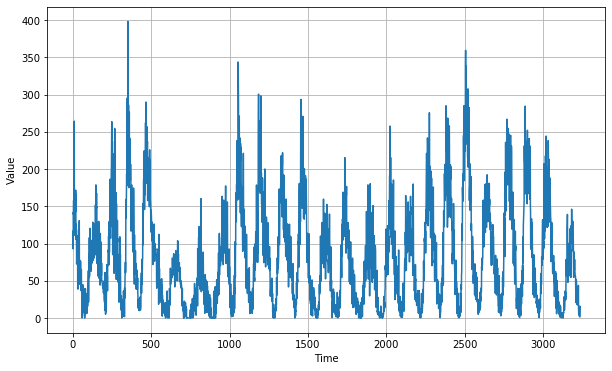

In [6]:
time_step = []
sunspots = []

with open('../data/Sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

## Defining Constants for Splitting and Windowing

In [7]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

## Building a Model

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 3s 235ms/step - loss: 79.8340 - mae: 80.3314 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 2s 188ms/step - loss: 78.0944 - mae: 78.5918 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 2s 205ms/step - loss: 75.4519 - mae: 75.9497 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 2s 207ms/step - loss: 72.2679 - mae: 72.7658 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 2s 190ms/step - loss: 68.7693 - mae: 69.2672 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 2s 182ms/step - loss: 65.1128 - mae: 65.6099 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 2s 180ms/step - loss: 61.5272 - mae: 62.0241 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 2s 180ms/step - loss: 58.1406 - mae: 58.

12/12 [==============================] - 2s 177ms/step - loss: 20.3574 - mae: 20.8502 - lr: 2.8184e-05
Epoch 71/100
12/12 [==============================] - 2s 180ms/step - loss: 21.6267 - mae: 22.1198 - lr: 3.1623e-05
Epoch 72/100
12/12 [==============================] - 2s 180ms/step - loss: 19.6867 - mae: 20.1793 - lr: 3.5481e-0532 - m
Epoch 73/100
12/12 [==============================] - 2s 180ms/step - loss: 19.1803 - mae: 19.6727 - lr: 3.9811e-05
Epoch 74/100
12/12 [==============================] - 2s 189ms/step - loss: 19.5618 - mae: 20.0548 - lr: 4.4668e-05
Epoch 75/100
12/12 [==============================] - 2s 197ms/step - loss: 19.8201 - mae: 20.3127 - lr: 5.0119e-05
Epoch 76/100
12/12 [==============================] - 2s 184ms/step - loss: 20.1610 - mae: 20.6535 - lr: 5.6234e-05
Epoch 77/100
12/12 [==============================] - 3s 212ms/step - loss: 20.9235 - mae: 21.4164 - lr: 6.3096e-05
Epoch 78/100
12/12 [==============================] - 2s 190ms/step - loss: 21.

Learning rate v. Loss

[1e-08, 0.0001, 0, 60]

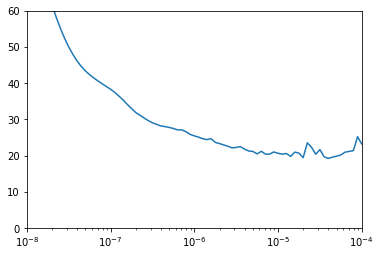

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

Using a modified Learning Rate

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 93ms/step - loss: 38.9180 - mae: 39.4144
Epoch 2/500
30/30 [==============================] - 3s 94ms/step - loss: 25.7664 - mae: 26.2609
Epoch 3/500
30/30 [==============================] - 3s 96ms/step - loss: 22.0765 - mae: 22.5702
Epoch 4/500
30/30 [==============================] - 3s 94ms/step - loss: 20.4550 - mae: 20.9478: 1s - loss: 20.182
Epoch 5/500
30/30 [==============================] - 3s 99ms/step - loss: 19.7479 - mae: 20.2404: 1s - loss: 19.1120 - mae: 19. - ETA: 1s - loss: 19.2147 
Epoch 6/500
30/30 [==============================] - 3s 95ms/step - loss: 19.3566 - mae: 19.8489
Epoch 7/500
30/30 [==============================] - 3s 96ms/step - loss: 18.5732 - mae: 19.0649: 1s - loss: 18.4942 
Epoch 8/500
30/30 [==============================] - 3s 99ms/step - loss: 18.2212 - mae: 18.7127
Epoch 9/500
30/30 [==============================] - 3s 98ms/step - loss: 18.0547 - mae: 18.5461
Epoch 10/500
30/30 [=========

30/30 [==============================] - 3s 114ms/step - loss: 16.4618 - mae: 16.9504
Epoch 79/500
30/30 [==============================] - 3s 110ms/step - loss: 16.4105 - mae: 16.8989
Epoch 80/500
30/30 [==============================] - 3s 111ms/step - loss: 16.6436 - mae: 17.1325
Epoch 81/500
30/30 [==============================] - 4s 118ms/step - loss: 16.7092 - mae: 17.1980
Epoch 82/500
30/30 [==============================] - 4s 120ms/step - loss: 16.4068 - mae: 16.8950
Epoch 83/500
30/30 [==============================] - 4s 130ms/step - loss: 16.3559 - mae: 16.8443
Epoch 84/500
30/30 [==============================] - 4s 124ms/step - loss: 16.3742 - mae: 16.8623
Epoch 85/500
30/30 [==============================] - 4s 122ms/step - loss: 16.4043 - mae: 16.8929
Epoch 86/500
30/30 [==============================] - 3s 104ms/step - loss: 16.8406 - mae: 17.3297
Epoch 87/500
30/30 [==============================] - 3s 113ms/step - loss: 16.7192 - mae: 17.2083
Epoch 88/500
30/30 [===

Epoch 158/500
30/30 [==============================] - 3s 93ms/step - loss: 15.9500 - mae: 16.4380: 1s - loss: 15.4783 - mae: 15.962 - ETA: 1s - loss: 15.8318 - mae: 16.317 - ETA: 1s - los
Epoch 159/500
30/30 [==============================] - 3s 95ms/step - loss: 16.1063 - mae: 16.5950
Epoch 160/500
30/30 [==============================] - 3s 93ms/step - loss: 15.9680 - mae: 16.4562
Epoch 161/500
30/30 [==============================] - 3s 91ms/step - loss: 15.9362 - mae: 16.4244
Epoch 162/500
30/30 [==============================] - 3s 93ms/step - loss: 16.1460 - mae: 16.6348
Epoch 163/500
30/30 [==============================] - 3s 93ms/step - loss: 16.2004 - mae: 16.6894
Epoch 164/500
30/30 [==============================] - 3s 94ms/step - loss: 15.9328 - mae: 16.4212: 1s - l
Epoch 165/500
30/30 [==============================] - 3s 94ms/step - loss: 15.9311 - mae: 16.4196: 1s - loss
Epoch 166/500
30/30 [==============================] - 3s 92ms/step - loss: 15.9954 - mae: 16.4842


30/30 [==============================] - 3s 100ms/step - loss: 15.5662 - mae: 16.0541 1s - lo
Epoch 238/500
30/30 [==============================] - 3s 103ms/step - loss: 15.7198 - mae: 16.2077
Epoch 239/500
30/30 [==============================] - 3s 97ms/step - loss: 15.9870 - mae: 16.4755: 0s - loss: 15.9952 - mae: 16.48
Epoch 240/500
30/30 [==============================] - 3s 96ms/step - loss: 15.6270 - mae: 16.1153: 2s - los
Epoch 241/500
30/30 [==============================] - 3s 95ms/step - loss: 15.7071 - mae: 16.1955
Epoch 242/500
30/30 [==============================] - 3s 99ms/step - loss: 15.6717 - mae: 16.1602: 2s - l
Epoch 243/500
30/30 [==============================] - 3s 95ms/step - loss: 15.7597 - mae: 16.2479
Epoch 244/500
30/30 [==============================] - 3s 91ms/step - loss: 15.5159 - mae: 16.0035
Epoch 245/500
30/30 [==============================] - 3s 94ms/step - loss: 15.5889 - mae: 16.0769
Epoch 246/500
30/30 [==============================] - 3s 94ms

30/30 [==============================] - 3s 94ms/step - loss: 15.2302 - mae: 15.7170: 1s - loss: 1
Epoch 317/500
30/30 [==============================] - 3s 116ms/step - loss: 15.1730 - mae: 15.6595
Epoch 318/500
30/30 [==============================] - 3s 101ms/step - loss: 15.2758 - mae: 15.7627
Epoch 319/500
30/30 [==============================] - 3s 93ms/step - loss: 15.3815 - mae: 15.8689
Epoch 320/500
30/30 [==============================] - 3s 93ms/step - loss: 15.2471 - mae: 15.7340
Epoch 321/500
30/30 [==============================] - 3s 91ms/step - loss: 15.2363 - mae: 15.7230
Epoch 322/500
30/30 [==============================] - 3s 91ms/step - loss: 15.4598 - mae: 15.9475
Epoch 323/500
30/30 [==============================] - 3s 103ms/step - loss: 15.1801 - mae: 15.6670
Epoch 324/500
30/30 [==============================] - 3s 97ms/step - loss: 15.1328 - mae: 15.6195: 1s - loss: 14.6921 - m - ETA: 0s - loss: 15.0247 - mae:
Epoch 325/500
30/30 [============================

30/30 [==============================] - 5s 177ms/step - loss: 14.9280 - mae: 15.4139
Epoch 396/500
30/30 [==============================] - 6s 200ms/step - loss: 15.0944 - mae: 15.5807 2s -
Epoch 397/500
30/30 [==============================] - 4s 117ms/step - loss: 14.9770 - mae: 15.4629
Epoch 398/500
30/30 [==============================] - 3s 114ms/step - loss: 15.1054 - mae: 15.5914
Epoch 399/500
30/30 [==============================] - 3s 109ms/step - loss: 14.9730 - mae: 15.4593
Epoch 400/500
30/30 [==============================] - 4s 138ms/step - loss: 15.0569 - mae: 15.5435
Epoch 401/500
30/30 [==============================] - 5s 178ms/step - loss: 15.0162 - mae: 15.5023
Epoch 402/500
30/30 [==============================] - 5s 172ms/step - loss: 14.9399 - mae: 15.4258 3s - loss: 
Epoch 403/500
30/30 [==============================] - 5s 162ms/step - loss: 14.8837 - mae: 15.3697
Epoch 404/500
30/30 [==============================] - 5s 179ms/step - loss: 14.9911 - mae: 15.47

30/30 [==============================] - 5s 155ms/step - loss: 14.6970 - mae: 15.1834
Epoch 477/500
30/30 [==============================] - 5s 154ms/step - loss: 14.6494 - mae: 15.1349
Epoch 478/500
30/30 [==============================] - 5s 179ms/step - loss: 14.5348 - mae: 15.0203
Epoch 479/500
30/30 [==============================] - 5s 162ms/step - loss: 14.5640 - mae: 15.0499
Epoch 480/500
30/30 [==============================] - 5s 161ms/step - loss: 14.5908 - mae: 15.0765
Epoch 481/500
30/30 [==============================] - 5s 162ms/step - loss: 14.5870 - mae: 15.0732
Epoch 482/500
30/30 [==============================] - 5s 162ms/step - loss: 14.8935 - mae: 15.3800
Epoch 483/500
30/30 [==============================] - 5s 177ms/step - loss: 14.5506 - mae: 15.0361
Epoch 484/500
30/30 [==============================] - 5s 176ms/step - loss: 14.5567 - mae: 15.0425
Epoch 485/500
30/30 [==============================] - 5s 157ms/step - loss: 14.5174 - mae: 15.0034
Epoch 486/500


## Forecasting

In [12]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

Plotting the forecast v. original series

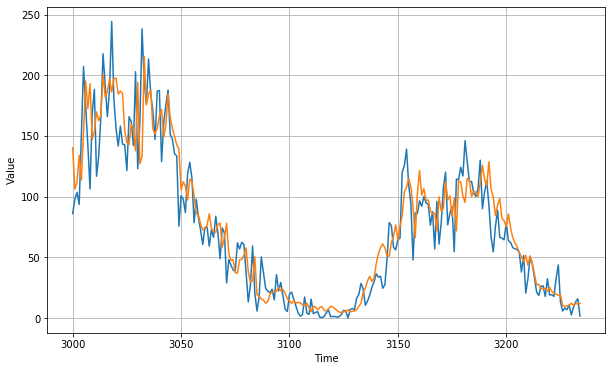

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

## MAE

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.489128

## Visualising Loss

<Figure size 432x288 with 0 Axes>

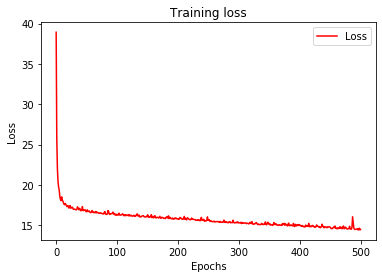

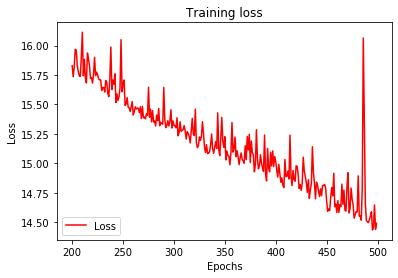

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()